In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction

Picking the right machine learning algorithm is critical because it decide the performance of the model. 

The model can be chosen based on performance often calculated by the `KFold-cross-validation` technique.

The high mean performance is better than the lower mean performance. But what if it caused by just a statistical luck? 

To address this issue, we can apply the **statistical hypothesis testing** to evaluate the difference in the mean performance resulting from the cross validation. If the difference is above the significance level `p-value` we can reject the null hypothesis that the two algorithms are the same. Hence we can pick the best ML model.  

# Tutorial Objectives

1. Model selection based on mean performance score could be misleading.
2. Why using the Paired Strudent's t-test over the original Student's t-test.
3. Applying the advance technique of 5X2 fold by utilizing the `MLxtend` library for comparing the algorithms based on `p-value` 


# Table of content

1. Extract the best two models
2. Steps to conduct hypothesis testing on the best two
3. Steps to apply the 5X2 fold
4. Comparing Classifier algorithms

# Loading dataset

For this tutorials, I will make use of the `load_iris` dataset within the `sklearn` library. However, the steps are the same for any ML problem. 

In [73]:
from sklearn.datasets import load_iris
# loading iris dataset as datafram
df = load_iris(as_frame = True)

In [74]:
df.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [75]:
dataset = df.data
dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [85]:
# define the target variable
y = df.target
y.shape

(150,)

In [86]:
# define the independent variables
X = df.data
X.shape

(150, 4)

In [77]:
# count how many classes per target - make sure it is a balance data
print(dataset.groupby(df.target).size())

target
0    50
1    50
2    50
dtype: int64


# Steps to extract the best two models

In this steps, I will conduct a comparasion between four different algorithms based on performance accuracy score. Then will select the two models with the highest score to conduct hypothesis testing between them.  

In [78]:
from numpy import mean, std
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [101]:
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [110]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression(max_iter=1000))) 
models.append(('LDA', LinearDiscriminantAnalysis())) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=1)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy') 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.964444 (0.041216)
LDA: 0.980000 (0.030551)
KNN: 0.964444 (0.037450)
SVM: 0.964444 (0.044666)


It seems that `LR` and `KNN` and `SVM` has same mean. However, `LDA` shows a higher mean accuracy over the rest of algorithms. Let's develop a boxplot betweeen `KNN` and `LDA` as a visualization for more interpretation. 

LDA Mean Accuracy: 0.980 (0.031)
KNeighborsClassifier Mean Accuracy: 0.964 (0.037)


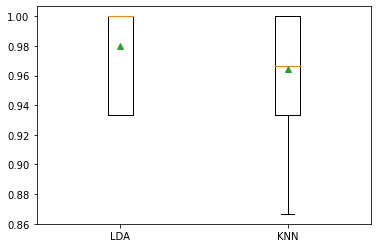

In [114]:
import matplotlib.pyplot as plt
# evaluate model 1
model1 = LinearDiscriminantAnalysis()
cv1 = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores1 = cross_val_score(model1, X, y, scoring = 'accuracy', cv = cv1, n_jobs = -1)
print('LDA Mean Accuracy: %.3f (%.3f)' % (mean(scores1), std(scores1)))

# evaluate model 2
model2 = KNeighborsClassifier()
cv2 = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores2 = cross_val_score(model2, X, y, scoring = 'accuracy', cv = cv2, n_jobs = -1)
print('KNeighborsClassifier Mean Accuracy: %.3f (%.3f)' % (mean(scores2), std(scores2)))

# plot the results
plt.boxplot([scores1, scores2], labels=['LDA', 'KNN'], showmeans=True)
plt.show()

Seems that LDA has a better performance over KNN where LDA has a higher accuracy.

Let's conduct a hypothesis test on those two algorithms to pick the best one.


# The intuition behind the 5X2 fold approach

One approach is to evaluate each model on the same k-fold cross-validation split of the data (e.g. using the same random number seed to split the data in each case) and calculate a score for each split. This would give a sample of 10 scores for 10-fold cross-validation. The scores can then be compared using a paired statistical hypothesis test because the same treatment (rows of data) was used for each algorithm to come up with each score. The Paired Student’s t-Test could be used.

A problem with using the Paired Student’s t-Test, in this case, is that each evaluation of the model is not independent. This is because the same rows of data are used to train the data multiple times — actually, each time, except for the time a row of data is used in the hold-out test fold. This lack of independence in the evaluation means that the Paired Student’s t-Test is optimistically biased.

This statistical test can be adjusted to take the lack of independence into account. Additionally, the number of folds and repeats of the procedure can be configured to achieve a good sampling of model performance that generalizes well to a wide range of problems and algorithms. Specifically two-fold cross-validation with five repeats, so-called 5×2-fold cross-validation.

This approach was proposed by Thomas Dietterich in his 1998 paper titled “Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms.”

In [115]:
from mlxtend.evaluate import paired_ttest_5x2cv
# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, 
                          estimator2=model2, 
                          X=X, 
                          y=y, 
                          scoring='accuracy', 
                          random_seed=1)
# summarize
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))
# interpret the result
if p <= 0.05:
    print('Difference between mean performance is probably real')
else:
    print('Algorithms probably have the same performance')

P-value: 0.229, t-Statistic: 1.369
Algorithms probably have the same performance
